In [1]:
import pandas as pd
data = pd.read_csv('lstm_monthly.csv', parse_dates = ['Issuance Date'], index_col = ['Issuance Date'])
data

,Quantity
Issuance Date,
2003-01-31,-0.032956
2003-02-28,0.000040
2003-03-31,0.000040
2003-04-30,0.000040
2003-05-31,0.000040
...,...
2022-12-31,0.373147
2023-01-31,-0.566194
2023-02-28,-0.678748


In [2]:
train = data.loc[:'2019-02-11',:]
val = data.loc['2019-02-11':,:]
val.shape

(51, 1)

In [3]:
import numpy as np
train = np.array(train)

In [4]:
val = np.array(val)
val.shape

(51, 1)

In [5]:

def generate_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        try:
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        except KeyError:
            break
    return np.array(X), np.array(y)

In [6]:
seq_length = 2
X_train, y_train = generate_sequences(train, seq_length)
X_val, y_val = generate_sequences(val, seq_length)

In [7]:
X_train.shape

(191, 2, 1)

In [8]:
X_val.shape

(49, 2, 1)

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=45, batch_input_shape=(1,2,1),  stateful = True, return_sequences = True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(units=30,  stateful = True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 2, 45)                8460      
_________________________________________________________________
batch_normalization (BatchNo (1, 2, 45)                180       
_________________________________________________________________
dropout (Dropout)            (1, 2, 45)                0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 30)                   9120      
_________________________________________________________________
batch_normalization_1 (Batch (1, 30)                   120       
_________________________________________________________________
dropout_1 (Dropout)          (1, 30)                   0         
_________________________________________________________________
dense (Dense)                (1, 64)                   1

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['RootMeanSquaredError'])
stop = EarlyStopping(monitor='val_loss', mode = 'min', patience = 30)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [11]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size = 1, shuffle = False, validation_split = 0.2, callbacks = [stop, mc])

Epoch 1/100
152/152 [==============================] - 6s 14ms/step - loss: 0.6397 - root_mean_squared_error: 0.7998 - val_loss: 2.9659 - val_root_mean_squared_error: 1.7222

Epoch 00001: val_loss improved from inf to 2.96589, saving model to best_model.h5
Epoch 2/100
152/152 [==============================] - 1s 7ms/step - loss: 0.6391 - root_mean_squared_error: 0.7995 - val_loss: 17.5682 - val_root_mean_squared_error: 4.1914

Epoch 00002: val_loss did not improve from 2.96589
Epoch 3/100
152/152 [==============================] - 1s 7ms/step - loss: 0.6381 - root_mean_squared_error: 0.7988 - val_loss: 764.4980 - val_root_mean_squared_error: 27.6496

Epoch 00003: val_loss did not improve from 2.96589
Epoch 4/100
152/152 [==============================] - 1s 7ms/step - loss: 0.6395 - root_mean_squared_error: 0.7997 - val_loss: 17046.6328 - val_root_mean_squared_error: 130.5627

Epoch 00004: val_loss did not improve from 2.96589
Epoch 5/100
152/152 [==============================] - 1s 

In [12]:
best_model = load_model('best_model.h5')

In [13]:
y_pred_arr = []
for i in range(0, 49, 1):
    x_test = X_val[i:i+1]
    y_pred = best_model.predict(x_test)
    y_pred_arr.append(y_pred)
y_pred_arr = np.array(y_pred_arr)
y_pred_arr = y_pred_arr.reshape(49, -1)
y_pred_arr.shape

(49, 1)

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_val, y_pred_arr)
mean = np.mean(y_val)
percent_mae = mae/mean *100
r2 = r2_score(y_val, y_pred_arr)
print (percent_mae)
print (r2)

-7573.9466009118205
-0.02848195786449237


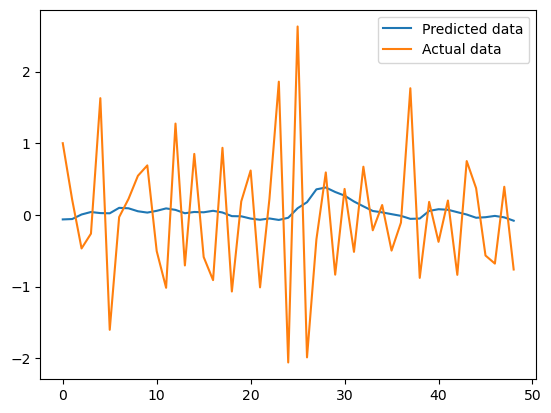

In [15]:
import matplotlib.pyplot as plt
plt.plot(y_pred_arr, label = 'Predicted data')
plt.plot(y_val, label = 'Actual data')
plt.legend()
plt.show()
